C:\Users\Girish\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Girish\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to C:\Users\Girish/.cache\torch\hub\checkpoints\regnet_y_400mf-c65dace8.pth


Using device: cpu


100%|██████████| 16.8M/16.8M [00:06<00:00, 2.66MB/s]


Epoch 1: Train Acc: 0.9021, Val Acc: 0.9579
Epoch 2: Train Acc: 0.9569, Val Acc: 0.9486
Epoch 3: Train Acc: 0.9785, Val Acc: 0.9813
Epoch 4: Train Acc: 0.9869, Val Acc: 1.0000
Epoch 5: Train Acc: 0.9922, Val Acc: 0.9953
Epoch 6: Train Acc: 0.9804, Val Acc: 0.9813
Epoch 7: Train Acc: 0.9915, Val Acc: 1.0000
Epoch 8: Train Acc: 0.9798, Val Acc: 0.9953
Epoch 9: Train Acc: 0.9824, Val Acc: 1.0000
Epoch 10: Train Acc: 0.9922, Val Acc: 0.9953


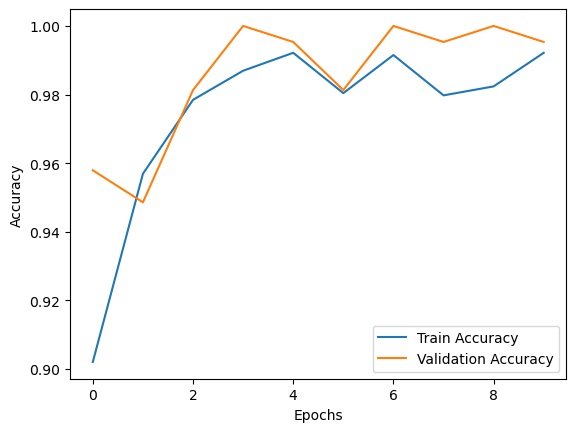

                  precision    recall  f1-score   support

bacterial_blight       1.00      1.00      1.00       114
            curl       0.99      1.00      1.00       106
  fussarium_wilt       1.00      0.99      1.00       107
         healthy       0.99      0.99      0.99       108

        accuracy                           1.00       435
       macro avg       1.00      1.00      1.00       435
    weighted avg       1.00      1.00      1.00       435



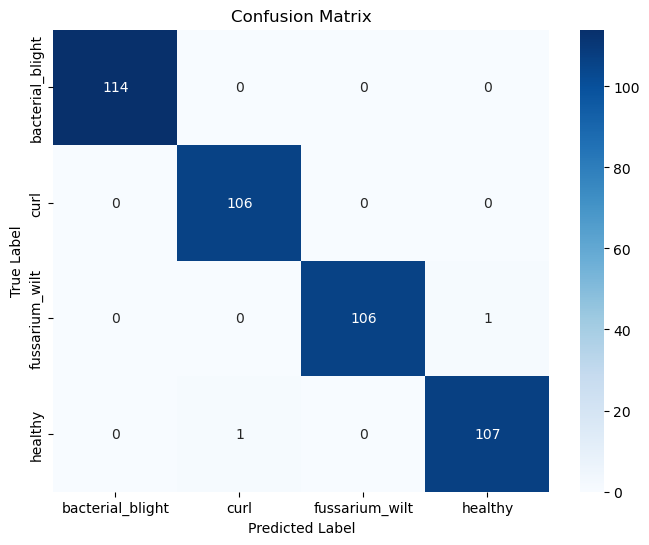

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(r"C:\Users\Girish\OneDrive\Documents\PROJ_SYN_COTTON-20250214T162900Z-001\PROJ_SYN_COTTON\DATA\train", transform=transform)
val_dataset = datasets.ImageFolder(r"C:\Users\Girish\OneDrive\Documents\PROJ_SYN_COTTON-20250214T162900Z-001\PROJ_SYN_COTTON\DATA\val", transform=transform)
test_dataset = datasets.ImageFolder(r"C:\Users\Girish\OneDrive\Documents\PROJ_SYN_COTTON-20250214T162900Z-001\PROJ_SYN_COTTON\DATA\test", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load RegNet model
model = models.regnet_y_400mf(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Adjust for the number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
        
        train_acc.append(correct / total)
        
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc.append(correct / total)
        print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    return train_acc, val_acc

# Train the model
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot Accuracy
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Testing and Metrics
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Test Accuracy: 0.9954
Precision: 0.9954
Recall: 0.9954
F1 Score: 0.9954


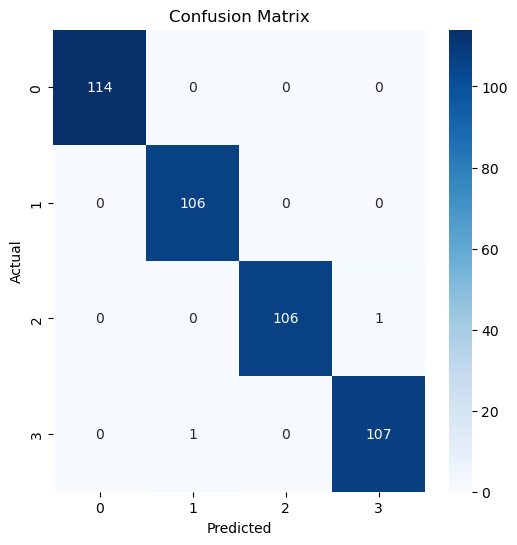

In [17]:
import torch

# Set model to evaluation mode
model.eval()

# Disable gradient calculations for faster inference
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Assuming you have a test DataLoader
        images = images.to(device)  # Move to GPU if available
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Now calculate accuracy, precision, recall, etc.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate Metrics
test_accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Using device: cpu


C:\Users\Girish\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Girish\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc: 0.9240, Val Acc: 0.8615
Epoch 2: Train Acc: 0.9708, Val Acc: 0.8577
Epoch 3: Train Acc: 0.9766, Val Acc: 0.8654
Epoch 4: Train Acc: 0.9800, Val Acc: 0.8923
Epoch 5: Train Acc: 0.9908, Val Acc: 0.8769
Epoch 6: Train Acc: 0.9866, Val Acc: 0.8885
Epoch 7: Train Acc: 0.9833, Val Acc: 0.8269
Epoch 8: Train Acc: 0.9800, Val Acc: 0.7769
Epoch 9: Train Acc: 0.9950, Val Acc: 0.8654
Epoch 10: Train Acc: 0.9875, Val Acc: 0.8192


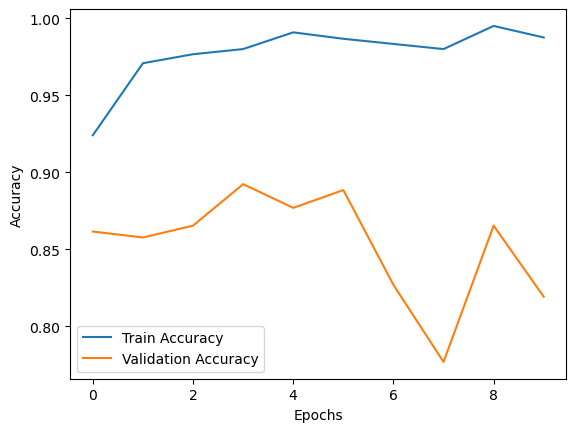

                  precision    recall  f1-score   support

bacterial_blight       0.95      0.87      0.91        67
      curl_virus       0.89      0.94      0.91        62
  fussarium_wilt       0.90      0.92      0.91        62
         healthy       0.94      0.97      0.95        64

        accuracy                           0.92       255
       macro avg       0.92      0.92      0.92       255
    weighted avg       0.92      0.92      0.92       255



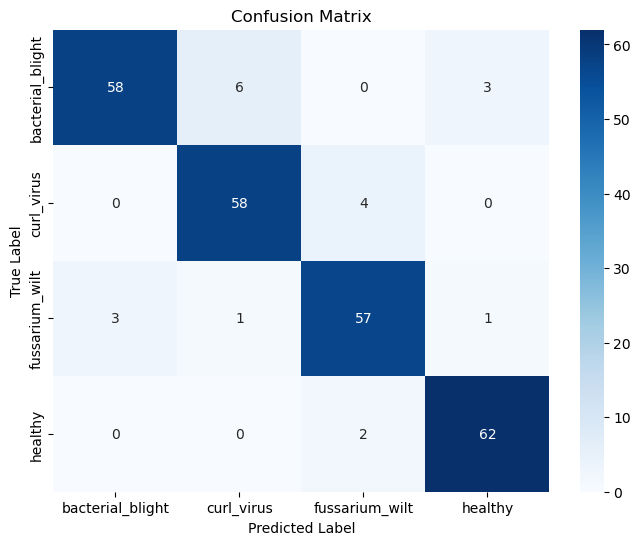

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(r"C:\Users\Girish\OneDrive\Documents\PROJ_SYN_COTTON-20250214T162900Z-001\PROJ_SYN_COTTON\Real_Data\train", transform=transform)
val_dataset = datasets.ImageFolder(r"C:\Users\Girish\OneDrive\Documents\PROJ_SYN_COTTON-20250214T162900Z-001\PROJ_SYN_COTTON\Real_Data\val", transform=transform)
test_dataset = datasets.ImageFolder(r"C:\Users\Girish\OneDrive\Documents\PROJ_SYN_COTTON-20250214T162900Z-001\PROJ_SYN_COTTON\Real_Data\test", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load RegNet model
model = models.regnet_y_400mf(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Adjust for the number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
        
        train_acc.append(correct / total)
        
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc.append(correct / total)
        print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    return train_acc, val_acc

# Train the model
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot Accuracy
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Testing and Metrics
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
import torch

# Set model to evaluation mode
model.eval()

# Disable gradient calculations for faster inference
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Assuming you have a test DataLoader
        images = images.to(device)  # Move to GPU if available
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Now calculate accuracy, precision, recall, etc.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate Metrics
test_accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Test Accuracy: 0.9216
Precision: 0.9225
Recall: 0.9216
F1 Score: 0.9213
